In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from tqdm import tqdm

# from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import re

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ratemeter/sample_submission.csv
/kaggle/input/ratemeter/train.csv
/kaggle/input/ratemeter/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/ratemeter/train.csv')
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,I finished this in two days. THIS SERIES IS JU...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,Review to follow \n Goodreads 4 \n Amazon 5 \n...,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,I will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. Aww! I loved this one! I have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,this is official: Patrick Ness is my fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [4]:
# train = train.iloc[:50000]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       630000 non-null  object
 1   book_id       630000 non-null  int64 
 2   review_id     630000 non-null  object
 3   review_text   630000 non-null  object
 4   date_added    630000 non-null  object
 5   date_updated  630000 non-null  object
 6   read_at       565775 non-null  object
 7   started_at    437963 non-null  object
 8   n_votes       630000 non-null  int64 
 9   n_comments    630000 non-null  int64 
 10  rating        630000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 52.9+ MB


In [5]:
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,I finished this in two days. THIS SERIES IS JU...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,Review to follow \n Goodreads 4 \n Amazon 5 \n...,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,I will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. Aww! I loved this one! I have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,this is official: Patrick Ness is my fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [6]:
train['rating'].value_counts()

rating
4    219581
5    185505
3    132280
2     50839
0     21692
1     20103
Name: count, dtype: int64

In [7]:
# Text Lowercasing
train['review_text'] = train['review_text'].str.lower()

In [8]:
# Tokenization
train['review_text'] = train['review_text'].apply(word_tokenize)

In [9]:
# Remove Punctuation and Non-Alphabetic Characters
train['review_text'] = train['review_text'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [10]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))
train['review_text'] = train['review_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [11]:
# lemmatizer = WordNetLemmatizer()
# train['review_text'] = train['review_text'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

In [12]:
# Stemmatizing
snow_stemmer = nltk.stem.SnowballStemmer('english')

train['review_text'] = train['review_text'].apply(lambda x: [snow_stemmer.stem(word) for word in x])

In [13]:
#  Reconstruct the Text
train['review_text'] = train['review_text'].apply(lambda tokens: ' '.join(tokens))
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,finish two day seri good stop fuck end,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,review follow goodread amazon overal,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,full review eventu initi hope thought shake br...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,star aww love one read seri order even though ...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,offici patrick ness fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [14]:
train = train.ffill(axis=1)

In [15]:
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,finish two day seri good stop fuck end,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,review follow goodread amazon overal,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,Sun Apr 28 20:23:22 -0700 2013,Sun Apr 28 20:23:22 -0700 2013,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,full review eventu initi hope thought shake br...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,star aww love one read seri order even though ...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,offici patrick ness fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,0,0,5


In [16]:
train['date_added'] = train['date_added'].apply(lambda date: date.split()[-1])
train['date_updated'] = train['date_updated'].apply(lambda date: date.split()[-1])

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       630000 non-null  object
 1   book_id       630000 non-null  object
 2   review_id     630000 non-null  object
 3   review_text   630000 non-null  object
 4   date_added    630000 non-null  object
 5   date_updated  630000 non-null  object
 6   read_at       630000 non-null  object
 7   started_at    630000 non-null  object
 8   n_votes       630000 non-null  object
 9   n_comments    630000 non-null  object
 10  rating        630000 non-null  object
dtypes: object(11)
memory usage: 52.9+ MB


In [18]:
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,finish two day seri good stop fuck end,2013,2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,review follow goodread amazon overal,2013,2013,Sun Apr 28 20:23:22 -0700 2013,Sun Apr 28 20:23:22 -0700 2013,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,full review eventu initi hope thought shake br...,2014,2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,star aww love one read seri order even though ...,2015,2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,offici patrick ness fav author,2013,2014,Tue Sep 16 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,0,0,5


In [19]:
def mtn(x):
    months = {'jan': 1,'feb': 2,'mar': 3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
    a = x.strip()[:3].lower()
    month_num = months[a]
    return month_num
    
train['read_at_month'] = train['read_at'].apply(lambda date: mtn(date.split()[1]))
train['read_at_year'] = train['read_at'].apply(lambda date: date.split()[-1])

In [20]:
train['started_at_month'] = train['started_at'].apply(lambda date: mtn(date.split()[1]))
train['started_at_year'] = train['started_at'].apply(lambda date: date.split()[-1])

In [21]:
train = train[['book_id','review_text','date_added','date_updated','n_votes','n_comments','read_at_month','read_at_year','started_at_month','started_at_year','rating']]

In [22]:
train.head()

,book_id,review_text,date_added,date_updated,n_votes,n_comments,read_at_month,read_at_year,started_at_month,started_at_year,rating
0,6547260,finish two day seri good stop fuck end,2013,2015,0,0,1,2015,1,2015,5
1,17201095,review follow goodread amazon overal,2013,2013,0,0,4,2013,4,2013,5
2,16143347,full review eventu initi hope thought shake br...,2014,2016,0,0,6,2014,6,2014,5
3,7863423,star aww love one read seri order even though ...,2015,2015,1,0,9,2015,9,2015,4
4,17262303,offici patrick ness fav author,2013,2014,0,0,9,2014,9,2014,5


In [23]:
train['book_id'] = train['book_id'].astype("int64")
train['date_added'] = train['date_added'].astype("int64")
train['date_updated'] = train['date_updated'].astype("int64")
train['n_votes'] = train['n_votes'].astype("int64")
train['n_comments'] = train['n_comments'].astype("int64")
train['started_at_year'] = train['started_at_year'].astype("int64")
train['read_at_year'] = train['read_at_year'].astype("int64")
train['rating'] = train['rating'].astype("int64")

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   book_id           630000 non-null  int64 
 1   review_text       630000 non-null  object
 2   date_added        630000 non-null  int64 
 3   date_updated      630000 non-null  int64 
 4   n_votes           630000 non-null  int64 
 5   n_comments        630000 non-null  int64 
 6   read_at_month     630000 non-null  int64 
 7   read_at_year      630000 non-null  int64 
 8   started_at_month  630000 non-null  int64 
 9   started_at_year   630000 non-null  int64 
 10  rating            630000 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 52.9+ MB


In [25]:
train.head()

,book_id,review_text,date_added,date_updated,n_votes,n_comments,read_at_month,read_at_year,started_at_month,started_at_year,rating
0,6547260,finish two day seri good stop fuck end,2013,2015,0,0,1,2015,1,2015,5
1,17201095,review follow goodread amazon overal,2013,2013,0,0,4,2013,4,2013,5
2,16143347,full review eventu initi hope thought shake br...,2014,2016,0,0,6,2014,6,2014,5
3,7863423,star aww love one read seri order even though ...,2015,2015,1,0,9,2015,9,2015,4
4,17262303,offici patrick ness fav author,2013,2014,0,0,9,2014,9,2014,5


In [26]:
# Open a file and use dump() 
with open('preprocessed.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(train, file) 

In [27]:
# Open the file in binary mode 
with open('preprocessed.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    train = pickle.load(file) 

In [28]:
tfidf = TfidfVectorizer(max_features = 20000, ngram_range=(1,3), analyzer='char')
X = tfidf.fit_transform(train['review_text'])
y = train['rating']

In [29]:
# Open a file and use dump() 
with open('vectorised.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(X, file) 

In [30]:
# Open the file in binary mode 
with open('vectorised.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    X = pickle.load(file) 

In [31]:
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)

<class 'scipy.sparse._csr.csr_matrix'>
<class 'pandas.core.series.Series'>
(630000, 15852)
(630000,)


In [32]:
print(train['book_id'].shape)

(630000,)


In [33]:
# Calculate correlation matrix
correlation_matrix = train[['book_id','date_updated','n_votes','n_comments','read_at_year','started_at_year','rating']].corr()

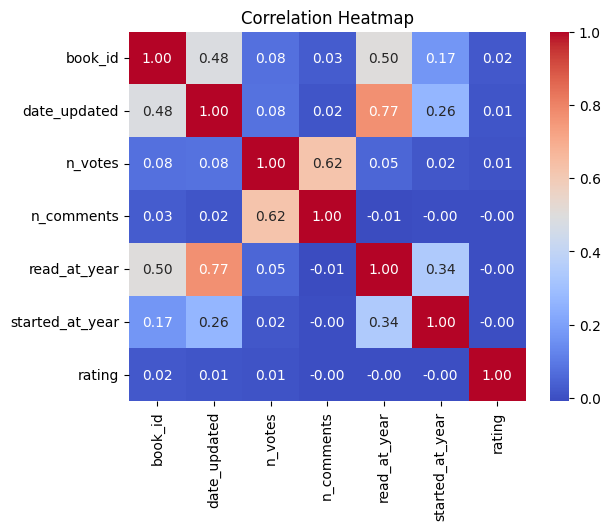

In [34]:
# Plot Heat map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [35]:
# import scipy as sp
# from scipy.sparse import csr_matrix

# X = sp.sparse.hstack(( X, csr_matrix(train['book_id']).T ))
# X = sp.sparse.hstack(( X, csr_matrix(train['date_updated']).T ))
# X = sp.sparse.hstack(( X, csr_matrix(train['n_votes']).T ))
# X = sp.sparse.hstack(( X, csr_matrix(train['n_comments']).T ))
# X = sp.sparse.hstack(( X, csr_matrix(train['read_at_year']).T ))
# X = sp.sparse.hstack(( X, csr_matrix(train['started_at_year']).T ))

In [36]:
print(X.shape)
print(X)

(630000, 15852)
  (0, 3600)	0.08265039931044685
  (0, 127)	0.07654656681357737
  (0, 6941)	0.12656841433314653
  (0, 2282)	0.09021025779342051
  (0, 12918)	0.160310246934887
  (0, 4419)	0.2274963268275132
  (0, 162)	0.11307207970973118
  (0, 10084)	0.17337524495626572
  (0, 9813)	0.12679539123406927
  (0, 12560)	0.15127014021386662
  (0, 12039)	0.08118788673308772
  (0, 519)	0.06553987287275602
  (0, 2627)	0.08622114754852181
  (0, 9496)	0.09830137021894027
  (0, 9789)	0.10014612491544106
  (0, 4887)	0.10889784787989744
  (0, 184)	0.07915918897600634
  (0, 5742)	0.11580420954398925
  (0, 11098)	0.0661092143336099
  (0, 3697)	0.08606761935748966
  (0, 11669)	0.10137770730721486
  (0, 504)	0.07133743931695424
  (0, 14897)	0.12613395952442724
  (0, 1379)	0.07787264168853573
  (0, 2661)	0.1465033045905472
  :	:
  (629999, 526)	0.05711405265265654
  (629999, 5105)	0.0066349289701191205
  (629999, 11726)	0.008438891456566656
  (629999, 6222)	0.015112509815333849
  (629999, 8981)	0.0165839419

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

In [38]:
X_train.shape, y_train.shape

((504000, 15852), (504000,))

In [39]:
SVC = LinearSVC()
SVC.fit(X_train, y_train)
y_pred_svc = SVC.predict(X_test)
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.56      0.20      0.29      4345
           1       0.47      0.18      0.26      4028
           2       0.39      0.12      0.19     10215
           3       0.43      0.34      0.38     26282
           4       0.47      0.61      0.53     44082
           5       0.57      0.64      0.61     37048

    accuracy                           0.50    126000
   macro avg       0.48      0.35      0.37    126000
weighted avg       0.49      0.50      0.48    126000



In [40]:
SVC_balanced = LinearSVC(class_weight='balanced')
SVC_balanced.fit(X_train, y_train)
y_pred_svc_balanced = SVC_balanced.predict(X_test)
print(classification_report(y_test, y_pred_svc_balanced))

              precision    recall  f1-score   support

           0       0.22      0.45      0.30      4345
           1       0.21      0.55      0.30      4028
           2       0.28      0.36      0.32     10215
           3       0.43      0.35      0.39     26282
           4       0.53      0.38      0.44     44082
           5       0.59      0.66      0.62     37048

    accuracy                           0.46    126000
   macro avg       0.38      0.46      0.39    126000
weighted avg       0.49      0.46      0.46    126000



In [41]:
#naive bayes classifier
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
y_pred_nb = naive_bayes_classifier.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.54      0.05      0.10      4345
           1       0.52      0.00      0.01      4028
           2       0.17      0.00      0.00     10215
           3       0.36      0.02      0.03     26282
           4       0.38      0.88      0.53     44082
           5       0.62      0.36      0.46     37048

    accuracy                           0.42    126000
   macro avg       0.43      0.22      0.19    126000
weighted avg       0.44      0.42      0.33    126000



In [42]:
test = pd.read_csv('/kaggle/input/ratemeter/test.csv')
test_original = test
test.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,de3a6a28c83cda006b415d45d64674c9,1618,d76ce5becf493e5c653610edb806ffc4,"I'm going to keep this review short, because I...",Tue Jun 09 10:37:48 -0700 2015,Wed Jun 10 13:43:38 -0700 2015,Wed Jun 10 14:08:39 -0700 2015,Tue Jun 09 00:00:00 -0700 2015,8,0
1,d9cfab35a87e32084b1817dfb0e98748,15776309,9c5c9aed79255a1a610dfc153ee90ad6,"You know, I was really stoked to see this come...",Mon Apr 22 09:19:40 -0700 2013,Wed Jul 10 14:34:27 -0700 2013,Wed Jul 10 14:34:27 -0700 2013,Tue Jul 09 00:00:00 -0700 2013,0,0
2,24935a870a46525a37be92775ab18f76,478927,ad26332459cda8f40581fef7a29b800c,This is one of those books where you know you ...,Sat Mar 14 12:16:55 -0700 2015,Sun Apr 05 11:25:00 -0700 2015,Wed Mar 18 00:00:00 -0700 2015,Sat Mar 14 00:00:00 -0700 2015,14,0
3,6ccb40eabdd0db7895aac00963256469,22628,5bb75768be7f2ddcd632336778b67f5a,The perks of being a wallflower \n What does a...,Sat Sep 12 08:43:30 -0700 2015,Sat Sep 12 09:19:29 -0700 2015,NaN,NaN,0,0
4,9f9d0f6e9a6a5797a252ef81abc9421c,13596809,3d7f76ea566b9ce0700772236094d936,"So, I wrote a review for this when I read it b...",Sun Jul 14 19:36:13 -0700 2013,Thu Jun 02 16:45:45 -0700 2016,Sat Mar 23 00:00:00 -0700 2013,NaN,0,0


In [43]:
# test_original = test_original.iloc[:10000]
# test = test.iloc[:10000]
test.shape

(270000, 10)

In [44]:
# Text Lowercasing
test['review_text'] = test['review_text'].str.lower()

In [45]:
# Tokenization
test['review_text'] = test['review_text'].apply(word_tokenize)

In [46]:
# Remove Punctuation and Non-Alphabetic Characters
test['review_text'] = test['review_text'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [47]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))
test['review_text'] = test['review_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [48]:
# Stemmatizing
snow_stemmer = nltk.stem.SnowballStemmer('english')

test['review_text'] = test['review_text'].apply(lambda x: [snow_stemmer.stem(word) for word in x])

In [49]:
#  Reconstruct the Text
test['review_text'] = test['review_text'].apply(lambda tokens: ' '.join(tokens))

In [50]:
test = test.ffill(axis=1)
test.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,de3a6a28c83cda006b415d45d64674c9,1618,d76ce5becf493e5c653610edb806ffc4,go keep review short feel like danger touchi s...,Tue Jun 09 10:37:48 -0700 2015,Wed Jun 10 13:43:38 -0700 2015,Wed Jun 10 14:08:39 -0700 2015,Tue Jun 09 00:00:00 -0700 2015,8,0
1,d9cfab35a87e32084b1817dfb0e98748,15776309,9c5c9aed79255a1a610dfc153ee90ad6,know realli stoke see come librari websit read...,Mon Apr 22 09:19:40 -0700 2013,Wed Jul 10 14:34:27 -0700 2013,Wed Jul 10 14:34:27 -0700 2013,Tue Jul 09 00:00:00 -0700 2013,0,0
2,24935a870a46525a37be92775ab18f76,478927,ad26332459cda8f40581fef7a29b800c,one book know want read year ago dream come tr...,Sat Mar 14 12:16:55 -0700 2015,Sun Apr 05 11:25:00 -0700 2015,Wed Mar 18 00:00:00 -0700 2015,Sat Mar 14 00:00:00 -0700 2015,14,0
3,6ccb40eabdd0db7895aac00963256469,22628,5bb75768be7f2ddcd632336778b67f5a,perk wallflow wallflow mean question edg pick ...,Sat Sep 12 08:43:30 -0700 2015,Sat Sep 12 09:19:29 -0700 2015,Sat Sep 12 09:19:29 -0700 2015,Sat Sep 12 09:19:29 -0700 2015,0,0
4,9f9d0f6e9a6a5797a252ef81abc9421c,13596809,3d7f76ea566b9ce0700772236094d936,wrote review read accident delet whole bunch r...,Sun Jul 14 19:36:13 -0700 2013,Thu Jun 02 16:45:45 -0700 2016,Sat Mar 23 00:00:00 -0700 2013,Sat Mar 23 00:00:00 -0700 2013,0,0


In [51]:
def mtn(x):
    months = {'jan': 1,'feb': 2,'mar': 3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
    a = x.strip()[:3].lower()
    month_num = months[a]
    return month_num

test['date_added'] = test['date_added'].apply(lambda date: date.split()[-1])
test['date_updated'] = test['date_updated'].apply(lambda date: date.split()[-1])   
test['read_at_month'] = test['read_at'].apply(lambda date: mtn(date.split()[1]))
test['read_at_year'] = test['read_at'].apply(lambda date: date.split()[-1])
test['started_at_month'] = test['started_at'].apply(lambda date: mtn(date.split()[1]))
test['started_at_year'] = test['started_at'].apply(lambda date: date.split()[-1])

In [52]:
test = test[['book_id','review_text','date_added','date_updated','n_votes','n_comments','read_at_month','read_at_year','started_at_month','started_at_year']]

In [53]:
test['book_id'] = test['book_id'].astype("int64")
test['date_added'] = test['date_added'].astype("int64")
test['date_updated'] = test['date_updated'].astype("int64")
test['n_votes'] = test['n_votes'].astype("int64")
test['n_comments'] = test['n_comments'].astype("int64")
test['started_at_year'] = test['started_at_year'].astype("int64")
test['read_at_year'] = test['read_at_year'].astype("int64")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   book_id           270000 non-null  int64 
 1   review_text       270000 non-null  object
 2   date_added        270000 non-null  int64 
 3   date_updated      270000 non-null  int64 
 4   n_votes           270000 non-null  int64 
 5   n_comments        270000 non-null  int64 
 6   read_at_month     270000 non-null  int64 
 7   read_at_year      270000 non-null  int64 
 8   started_at_month  270000 non-null  int64 
 9   started_at_year   270000 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 20.6+ MB


In [54]:
test.head()

,book_id,review_text,date_added,date_updated,n_votes,n_comments,read_at_month,read_at_year,started_at_month,started_at_year
0,1618,go keep review short feel like danger touchi s...,2015,2015,8,0,6,2015,6,2015
1,15776309,know realli stoke see come librari websit read...,2013,2013,0,0,7,2013,7,2013
2,478927,one book know want read year ago dream come tr...,2015,2015,14,0,3,2015,3,2015
3,22628,perk wallflow wallflow mean question edg pick ...,2015,2015,0,0,9,2015,9,2015
4,13596809,wrote review read accident delet whole bunch r...,2013,2016,0,0,3,2013,3,2013


In [55]:
# Open a file and use dump() 
with open('preprocessed_test.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(test, file) 

In [56]:
# Open the file in binary mode 
with open('preprocessed_test.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    test = pickle.load(file) 

In [57]:
# tfidf = TfidfVectorizer(max_features = 1000, ngram_range=(1,3), analyzer='char')
X_t = tfidf.transform(test['review_text'])
# y_t = test['rating']

In [58]:
# Open a file and use dump() 
with open('vectorised_test.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(X_t, file) 

In [59]:
# Open the file in binary mode 
with open('vectorised_test.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    X_t = pickle.load(file) 

In [60]:
print(type(X_t))
print(X_t.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(270000, 15852)


In [61]:
# import scipy as sp
# from scipy.sparse import csr_matrix

# X_t = sp.sparse.hstack(( X_t, csr_matrix(test['book_id']).T ))
# X_t = sp.sparse.hstack(( X_t, csr_matrix(test['date_updated']).T ))
# X_t = sp.sparse.hstack(( X_t, csr_matrix(test['n_votes']).T ))
# X_t = sp.sparse.hstack(( X_t, csr_matrix(test['n_comments']).T ))
# X_t = sp.sparse.hstack(( X_t, csr_matrix(test['read_at_year']).T ))
# X_t = sp.sparse.hstack(( X_t, csr_matrix(test['started_at_year']).T ))

In [62]:
print(type(X_t))
print(X_t.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(270000, 15852)


In [63]:
y_pred_svc_test = SVC.predict(X_t)
print(y_pred_svc_test)
print("=====")
print(type(y_pred_svc_test))
print("=====")
print(len(y_pred_svc_test))

[3 4 5 ... 4 3 5]
=====
<class 'numpy.ndarray'>
=====
270000


In [64]:
y_pred_svc_balanced_test = SVC_balanced.predict(X_t)
print(y_pred_svc_balanced_test)
print("=====")
print(type(y_pred_svc_balanced_test))
print("=====")
print(len(y_pred_svc_balanced_test))

[3 2 5 ... 0 3 5]
=====
<class 'numpy.ndarray'>
=====
270000


In [65]:
y_pred_nb_test = naive_bayes_classifier.predict(X_t)
print(y_pred_nb_test)
print("=====")
print(type(y_pred_nb_test))
print("=====")
print(len(y_pred_nb_test))

[4 4 4 ... 4 4 5]
=====
<class 'numpy.ndarray'>
=====
270000


In [66]:
review_id_list = test_original['review_id'].to_numpy()
print(review_id_list)
print(type(review_id_list))

['d76ce5becf493e5c653610edb806ffc4' '9c5c9aed79255a1a610dfc153ee90ad6'
 'ad26332459cda8f40581fef7a29b800c' ... '7accbbf4c7f3e991c6439e11bdd3a94a'
 'b7dc269df1bbb4464d633dc54ca1c40e' 'a729306718fc2edfab0fcb056d17068e']
<class 'numpy.ndarray'>


In [67]:
data_svc = {'review_id': review_id_list,
        'rating': y_pred_svc_test}


output_df_svc = pd.DataFrame(data_svc)
print(output_df_svc.shape)
output_df_svc.head()

(270000, 2)


,review_id,rating
0,d76ce5becf493e5c653610edb806ffc4,3
1,9c5c9aed79255a1a610dfc153ee90ad6,4
2,ad26332459cda8f40581fef7a29b800c,5
3,5bb75768be7f2ddcd632336778b67f5a,5
4,3d7f76ea566b9ce0700772236094d936,5


In [68]:
# saving the dataframe
output_df_svc.to_csv('output_svc.csv',header=True,index=False)

In [69]:
data_svc_balanced = {'review_id': review_id_list,
        'rating': y_pred_svc_balanced_test}

output_df_svc_balanced = pd.DataFrame(data_svc_balanced)
print(output_df_svc_balanced.shape)
output_df_svc_balanced.head()

(270000, 2)


,review_id,rating
0,d76ce5becf493e5c653610edb806ffc4,3
1,9c5c9aed79255a1a610dfc153ee90ad6,2
2,ad26332459cda8f40581fef7a29b800c,5
3,5bb75768be7f2ddcd632336778b67f5a,5
4,3d7f76ea566b9ce0700772236094d936,0


In [70]:
# saving the dataframe
output_df_svc_balanced.to_csv('output_svc_balanced.csv',header=True,index=False)

In [71]:
data_nb = {'review_id': review_id_list,
        'rating': y_pred_nb_test}

output_df_nb = pd.DataFrame(data_nb)
print(output_df_nb.shape)
output_df_nb.head()

(270000, 2)


,review_id,rating
0,d76ce5becf493e5c653610edb806ffc4,4
1,9c5c9aed79255a1a610dfc153ee90ad6,4
2,ad26332459cda8f40581fef7a29b800c,4
3,5bb75768be7f2ddcd632336778b67f5a,4
4,3d7f76ea566b9ce0700772236094d936,4


In [72]:
# saving the dataframe
output_df_nb.to_csv('output_nb.csv',header=True,index=False)